In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tsai.all import *

torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from wingbeat_datasets import *
from wingbeat_models import *

print(f'Total RAM      : {bytes2GB(psutil.virtual_memory().total):5.2f} GB')
print(f'Available RAM  : {bytes2GB(psutil.virtual_memory().available):5.2f} GB\n')

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Available workers: 16
Total RAM      : 31.21 GB
Available RAM  : 25.47 GB



In [3]:
num_epochs = 35
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'conv1draw'
normalize = "sample"

In [4]:
transforms_list = [FilterWingbeat(setting='bandpass')]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", transform=transforms.Compose(transforms_list)).clean()
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", transform=transforms.Compose(transforms_list)).clean()
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample": # normalize each sample
    transforms_list += [Normalize()]
else:
    pass

# dmel1 = WingbeatsDataset(dsname="Wingbeats/Y", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()
# dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], transform=transforms.Compose(transforms_list)).clean()
# dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], transform=transforms.Compose(transforms_list)).clean()
# dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], transform=transforms.Compose(transforms_list)).clean()
dset = WingbeatsDataset(dsname="Wingbeats", transform=transforms.Compose(transforms_list)).clean()

Found 279566 in dataset: Wingbeats, and 6 label(s): ['Ae. aegypti' 'Ae. albopictus' 'An. arabiensis' 'An. gambiae'
 'C. pipiens' 'C. quinquefasciatus']
No custom label applied.
Nr. of valid wingbeats: 278307


In [5]:
transformed_dataset = dset
trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)
train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers)

In [6]:
all_labels = ()
for x,y,path,idx in tqdm(train_dataloader):
#     print(f"x:{x},\ny:{y},\npath:{path},\nidx:{idx}")
    all_labels += y
#     print(y)
#     break

100%|██████████| 6958/6958 [00:30<00:00, 231.83it/s]


In [7]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
lb.fit(all_labels)

def encodelabels(ybatch):
    return torch.from_numpy(lb.transform(ybatch))

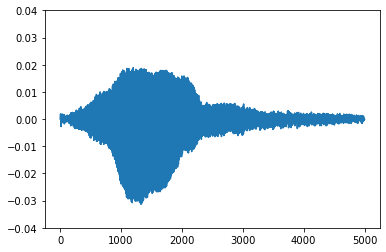

In [8]:
from IPython.display import Audio
sig = train_dataset[6][0]
plt.plot(sig.T); plt.ylim(-.04,.04)
Audio(sig, rate=8000, autoplay=True)

In [9]:
if setting.startswith('psd'):
    model = Conv1dNetPSD()
elif modeltype == 'conv1draw':
    model = Conv1dNetRAW()
elif modeltype == 'inception':
    model = nn.Sequential(
                    InceptionBlock(
                        in_channels=1, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=2))

num_ftrs = model.fc1.in_features
model.fc1 = nn.Linear(num_ftrs,6) 
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=7, verbose=1)
# print(model)

In [10]:
model

Conv1dNetRAW(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(128, 256, kernel_size=(3,), stride=(1,)

In [11]:
# list(model.children())[0]

In [12]:
# test if everything works with mock input
# import torchsummary
# torchsummary.summary(model, (1,10000))
# x = torch.randn(32, 1, 5000)

# output = model(x)
# output

## Training

In [13]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(train_dataloader, desc='Training..\t'):        

        y_batch = encodelabels(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()

    train_accuracy = correct_train / (len(train_dataloader)*batch_size) * 100.
    # Going through the validation set
    correct_valid = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(valid_dataloader, desc='Validating..\t'):
        
        y_batch = encodelabels(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()
        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
    valid_accuracy = correct_valid / (len(valid_dataloader)*batch_size_val) * 100.
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

        # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.2f}% loss: {loss:.3f},  val_loss: {val_loss:.3f} val_acc: {valid_accuracy:.2f}%")


Train on gpu: True


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Validation loss decreased (inf --> 26.226006).  Saving model ...
Epoch 0: train_acc: 75.22% loss: 0.263,  val_loss: 26.226 val_acc: 7.26%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Epoch 1: train_acc: 81.22% loss: 0.276,  val_loss: 55.149 val_acc: 7.91%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Epoch 2: train_acc: 83.32% loss: 0.293,  val_loss: 28.945 val_acc: 10.09%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Epoch 3: train_acc: 84.54% loss: 0.349,  val_loss: 36.413 val_acc: 10.24%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Validation loss decreased (26.226006 --> 5.187073).  Saving model ...
Epoch 4: train_acc: 85.36% loss: 0.212,  val_loss: 5.187 val_acc: 14.32%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Validation loss decreased (5.187073 --> 2.490898).  Saving model ...
Epoch 5: train_acc: 85.82% loss: 0.281,  val_loss: 2.491 val_acc: 30.71%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Epoch 6: train_acc: 86.41% loss: 0.276,  val_loss: 3.744 val_acc: 14.22%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Epoch 7: train_acc: 86.84% loss: 0.226,  val_loss: 12.071 val_acc: 11.90%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Epoch 8: train_acc: 87.15% loss: 0.262,  val_loss: 59.028 val_acc: 12.72%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Epoch    10: reducing learning rate of group 0 to 1.0000e-03.
Epoch 9: train_acc: 87.44% loss: 0.292,  val_loss: 2.946 val_acc: 36.58%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Epoch 10: train_acc: 89.45% loss: 0.154,  val_loss: 23.297 val_acc: 26.41%


Training..	:   0%|          | 0/6958 [00:00<?, ?it/s]

Epoch 11: train_acc: 89.83% loss: 0.204,  val_loss: 8.117 val_acc: 35.77%


Validating..	: 100%|██████████| 870/870 [00:07<00:00, 115.34it/s]

Early stopping


## Testing

### testing on datasets with same conditions

In [14]:
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

Train on gpu: True


In [15]:
test_dataset = ConcatDataset([dmel2, dsuz2])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers)

def test(model, test_dataloader):
    correct_test = 0
    model.eval()
    for x_batch,y_batch,path_batch,idx_batch in tqdm(test_dataloader, desc='Testing..\t'):

        y_batch = torch.as_tensor(y_batch).type(torch.LongTensor)
        x_batch,y_batch = x_batch.cuda(), y_batch.cuda()

        pred = model(x_batch)
        val_loss = criterion(pred, y_batch)
        correct_test += (pred.argmax(axis=1) == y_batch).float().sum().item()
    test_accuracy = correct_test / (len(test_dataloader)*batch_size_val) * 100.
    print(test_accuracy)

NameError: name 'dmel2' is not defined

In [ ]:
test(model,test_dataloader)